In [1]:
%pylab inline

import numpy as np
import scipy.stats as stats
import pymc3 as pm
import theano
import theano.tensor as tt
floatX = "float32"

%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Set up data

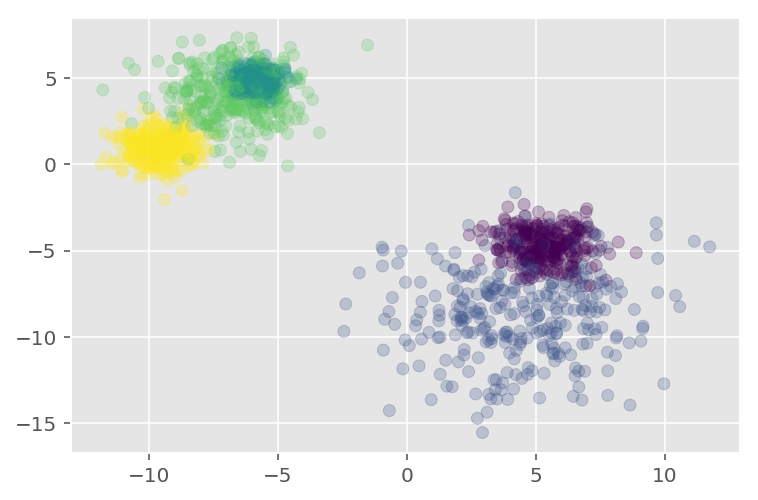

In [2]:
from sklearn.datasets import make_blobs

n_samples = 1500
cluster_std = [1.0, 2.5, 0.5, 1.5, .8]
X, y = make_blobs(n_samples=n_samples, 
                  cluster_std=cluster_std,
                  centers=len(cluster_std))

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.viridis, alpha=.25);

In [3]:
X.shape

(1500, 2)

In [4]:
for i in range(len(cluster_std)):
    print('\nmu = ', np.mean(X[y==i, :], axis=0))
    print('var = ', np.square(cluster_std[i]))
    print('cov = ', np.cov(X[y==i, :].T))


mu =  [ 5.33784411 -4.73690856]
var =  1.0
cov =  [[ 1.06261903 -0.07640335]
 [-0.07640335  0.84162951]]

mu =  [ 4.40324001 -8.65656276]
var =  6.25
cov =  [[6.69550291 0.49480838]
 [0.49480838 6.25118834]]

mu =  [-5.83580202  4.85357218]
var =  0.25
cov =  [[ 0.24426803 -0.00994821]
 [-0.00994821  0.2421605 ]]

mu =  [-6.76464808  3.96996677]
var =  2.25
cov =  [[ 2.08835256 -0.06742747]
 [-0.06742747  2.12231638]]

mu =  [-9.59471545  0.99110059]
var =  0.6400000000000001
cov =  [[0.6870151  0.03194105]
 [0.03194105 0.6538491 ]]


# Kmeans and deterministic GMM

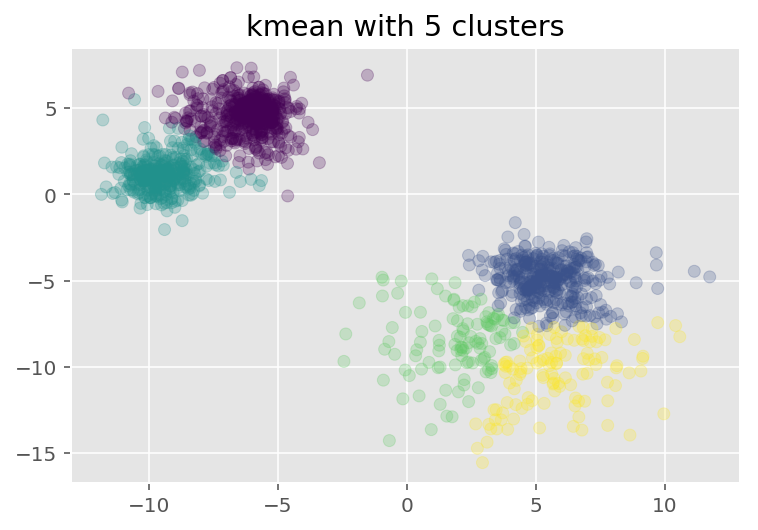

In [5]:
from sklearn.cluster import KMeans
nk = 5
# Incorrect number of clusters
y1 = KMeans(n_clusters=5, 
                n_init=50, 
                ).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y1, cmap=plt.cm.viridis, alpha=.25);
plt.title("kmean with %s clusters" %nk);

# Bayesian GMM from sklearn

Using `sklearn.mixture.BayesianGaussianMixture`, it applies a point-prior for weight, means, and precision matrices.
See https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/mixture/bayesian_mixture.py for more details

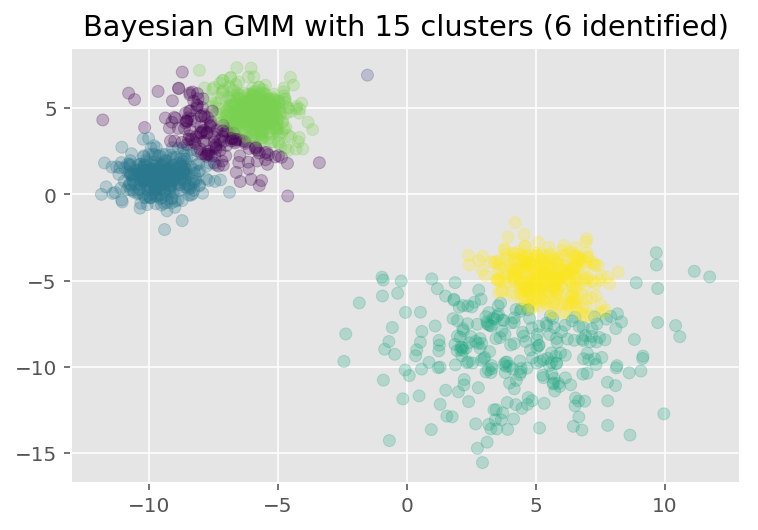

In [6]:
from sklearn.mixture import BayesianGaussianMixture as BayesGMM
K = 15
# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = BayesGMM(n_components=K,
                 n_init=50,
                 covariance_type='full').fit(X)
y2 = dpgmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y2, cmap=plt.cm.viridis, alpha=.25);
plt.title("Bayesian GMM with %s clusters (%s identified)" % (K, len(np.unique(y2))));

# Bayesian GMM using PyMC3

Based on https://github.com/pymc-devs/pymc3/blob/master/docs/source/notebooks/gaussian-mixture-model-advi.ipynb  
see also  
https://gist.github.com/AustinRochford/41109579c8be23a10e2cd167209dbe25  
https://gist.github.com/AustinRochford/e45b7e5f7d18d77f391d3373801e4c9a  

In [7]:
nk = 5
with pm.Model() as model:
    w = pm.Dirichlet('w', np.ones(nk))

    comp_dist = []
    mu = []
    packed_chol = []
    chol = []
    for i in range(nk):
        mu.append(pm.Normal('mu%i'%i, 0, 10, shape=2))
        packed_chol.append(pm.LKJCholeskyCov('chol_cov_%i'%i,
                                             eta=2, 
                                             n=2, 
                                             sd_dist=pm.HalfNormal.dist(2.5)))
        chol.append(pm.expand_packed_triangular(2, packed_chol[i], lower=True))
        comp_dist.append(pm.MvNormal.dist(mu=mu[i], chol=chol[i]))

    xobs = pm.Mixture('x_obs', w, comp_dist,
            observed=X)

In [8]:
complogp = xobs.distribution._comp_logp(theano.shared(X))
f_complogp = model.model.fastfn(complogp)

In [19]:
point = model.test_point
point

{'chol_cov_0_cholesky-cov-packed__': array([0., 0., 0.]),
 'chol_cov_1_cholesky-cov-packed__': array([0., 0., 0.]),
 'chol_cov_2_cholesky-cov-packed__': array([0., 0., 0.]),
 'chol_cov_3_cholesky-cov-packed__': array([0., 0., 0.]),
 'chol_cov_4_cholesky-cov-packed__': array([0., 0., 0.]),
 'mu0': array([0., 0.]),
 'mu1': array([0., 0.]),
 'mu2': array([0., 0.]),
 'mu3': array([0., 0.]),
 'mu4': array([0., 0.]),
 'w_stickbreaking__': array([0., 0., 0., 0.])}

In [20]:
cholunpack = pm.distributions.transforms.CholeskyCovPacked(2)
for i in range(len(cluster_std)):
    point['mu%i'%i] = np.mean(X[y==i, :], axis=0)
    covpack = np.array([1., 0., 1.])
    point['chol_cov_%i_cholesky-cov-packed__'%i] = cholunpack.forward(covpack*np.square(cluster_std[i])).eval()
    
point

{'chol_cov_0_cholesky-cov-packed__': array([0., 0., 0.]),
 'chol_cov_1_cholesky-cov-packed__': array([1.83258146, 0.        , 1.83258146]),
 'chol_cov_2_cholesky-cov-packed__': array([-1.38629436,  0.        , -1.38629436]),
 'chol_cov_3_cholesky-cov-packed__': array([0.81093022, 0.        , 0.81093022]),
 'chol_cov_4_cholesky-cov-packed__': array([-0.4462871,  0.       , -0.4462871]),
 'mu0': array([ 5.33784411, -4.73690856]),
 'mu1': array([ 4.40324001, -8.65656276]),
 'mu2': array([-5.83580202,  4.85357218]),
 'mu3': array([-6.76464808,  3.96996677]),
 'mu4': array([-9.59471545,  0.99110059]),
 'w_stickbreaking__': array([0., 0., 0., 0.])}

In [21]:
y_ = np.argmax(f_complogp(point), axis=1)
y_

array([0, 3, 3, ..., 2, 1, 3])

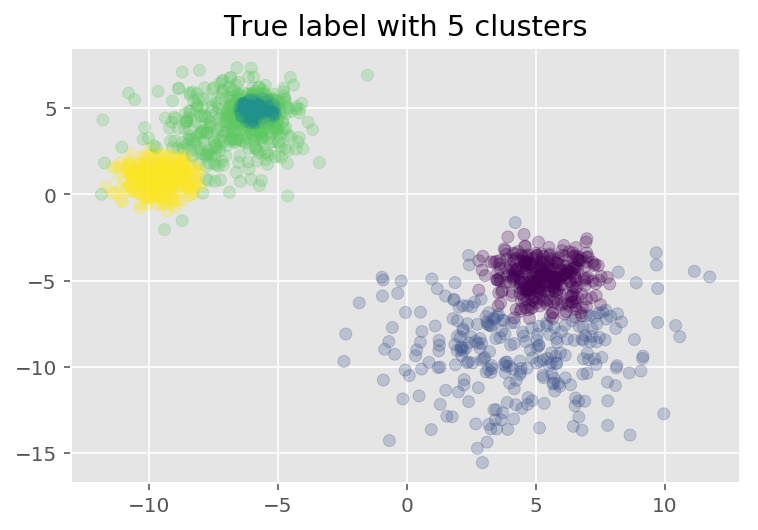

In [22]:
plt.scatter(X[:, 0], X[:, 1], c=y_, cmap=plt.cm.viridis, alpha=.25);
plt.title("True label with %s clusters" %nk);

In [23]:
with model:
    trace = pm.sample(1000, tune=1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [chol_cov_4, mu4, chol_cov_3, mu3, chol_cov_2, mu2, chol_cov_1, mu1, chol_cov_0, mu0, w]
100%|██████████| 2000/2000 [01:10<00:00, 28.55it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


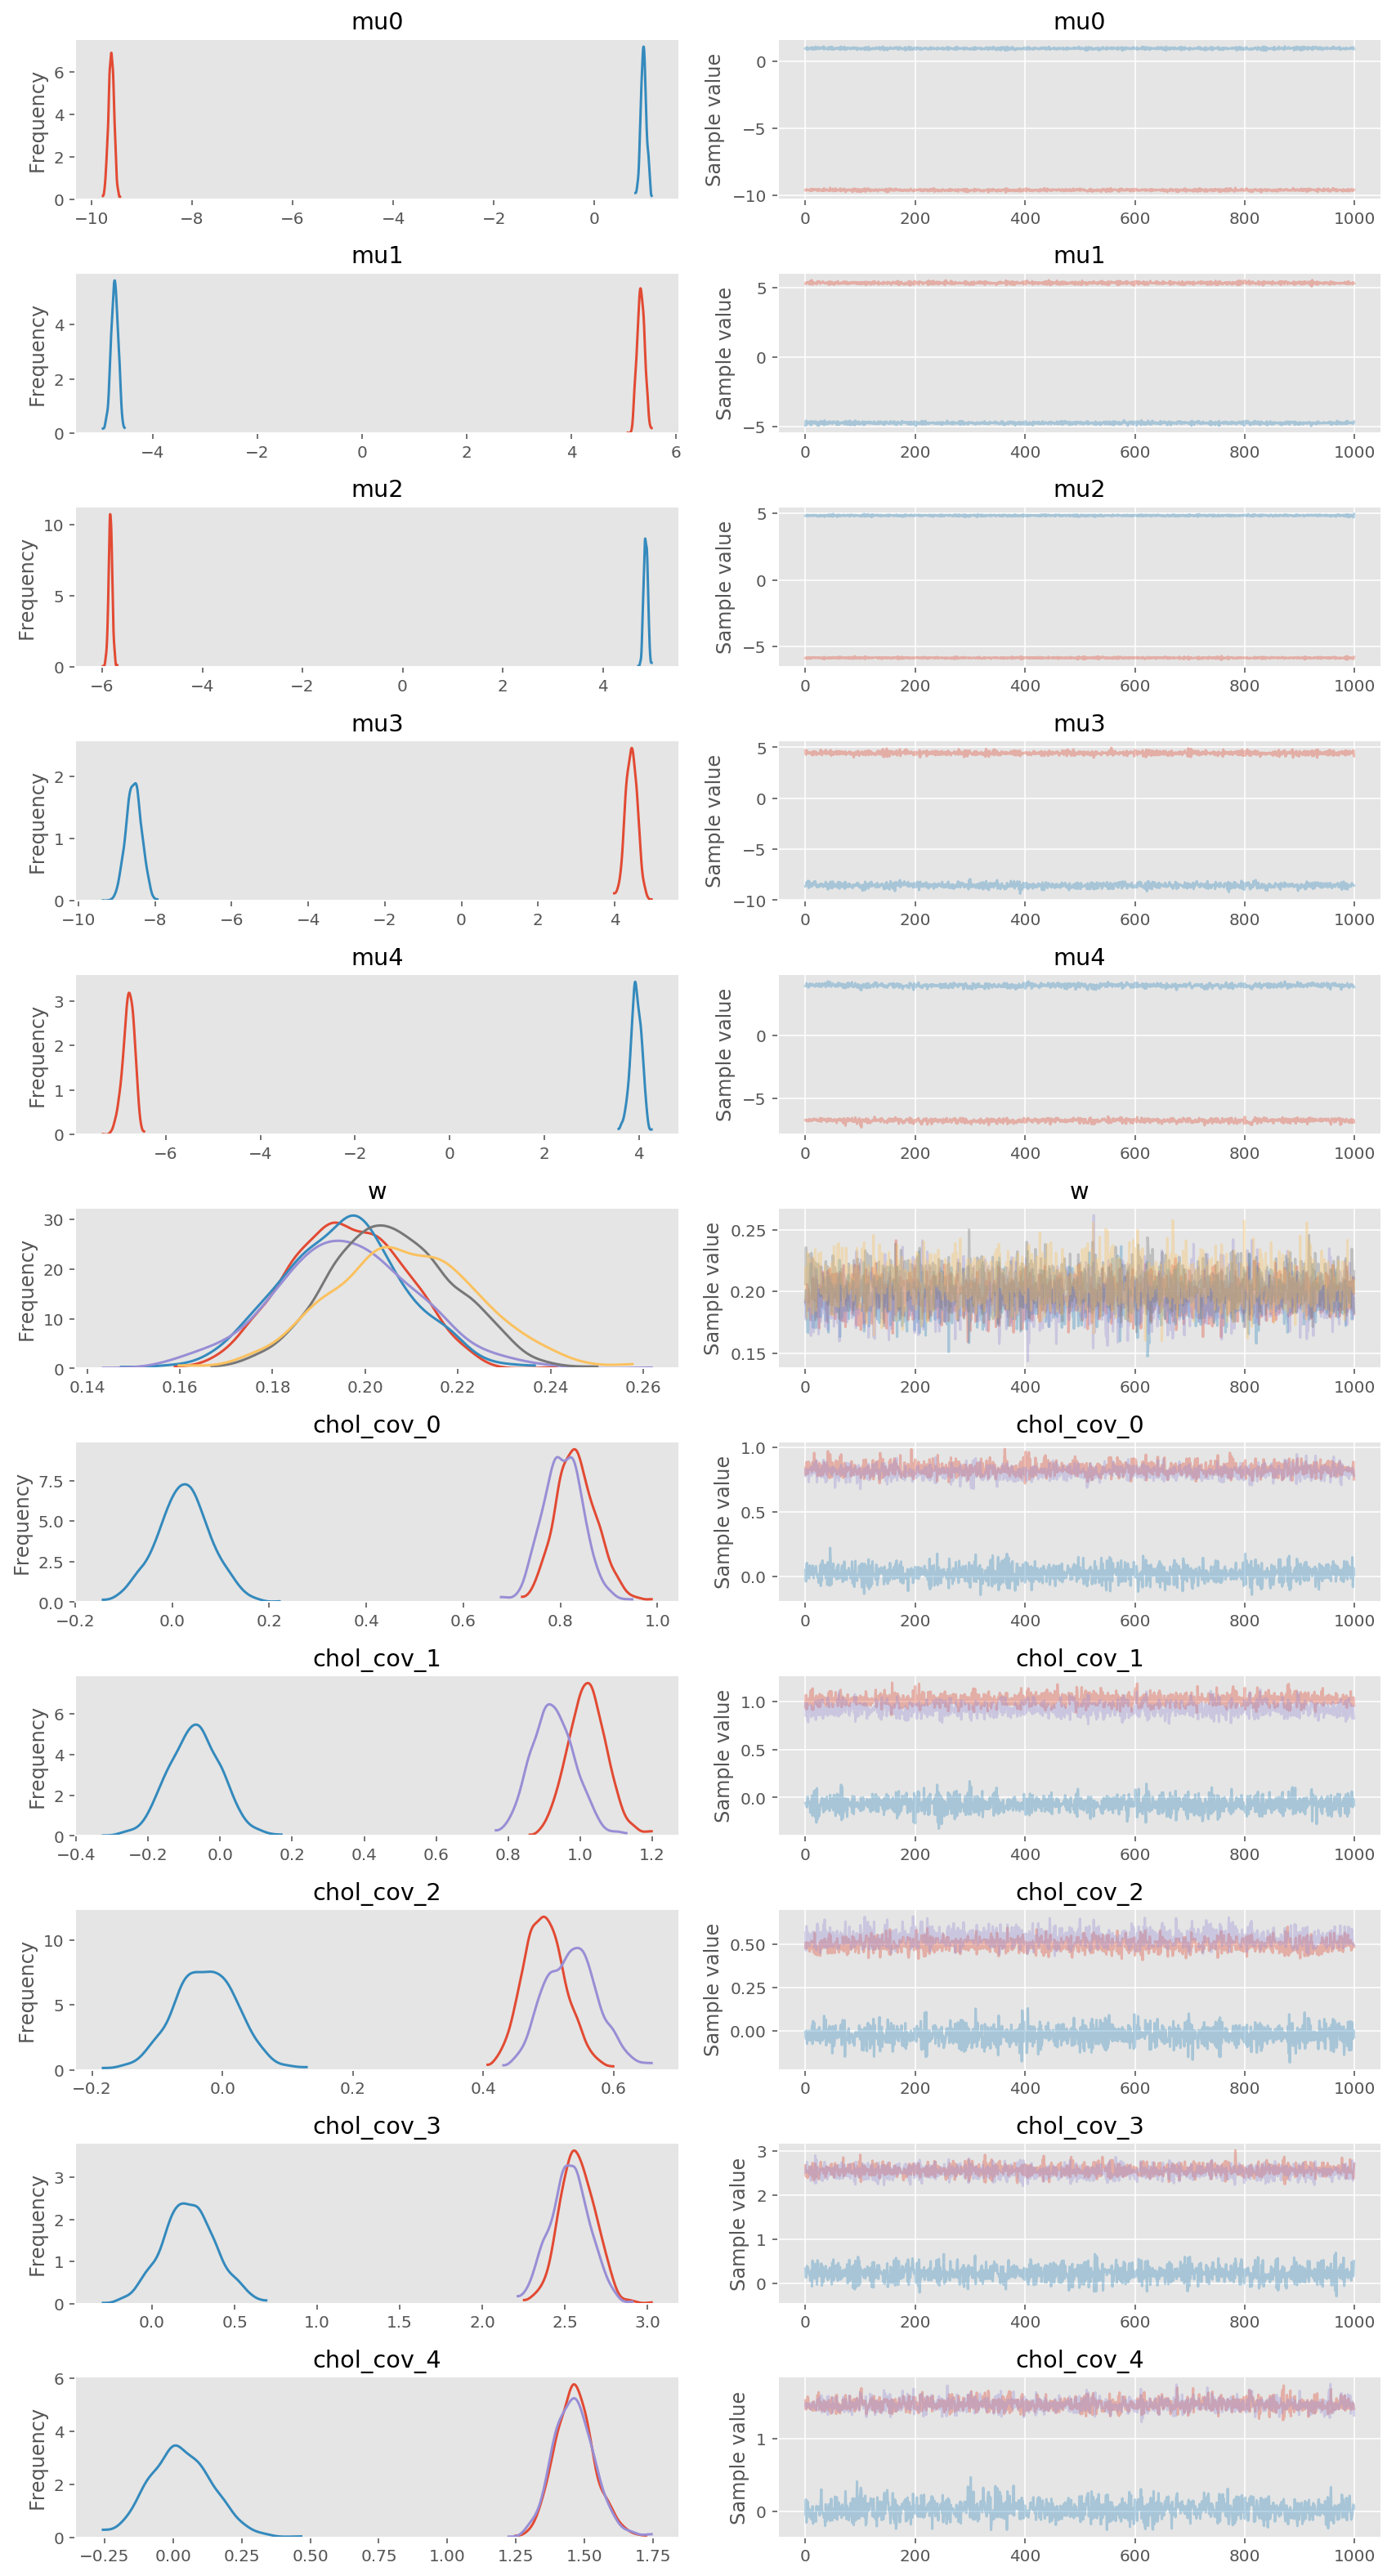

In [24]:
pm.traceplot(trace);

In [26]:
for i in range(len(cluster_std)):
    point['mu%i'%i] = np.mean(trace['mu%i'%i], axis=0)
    chollabel = 'chol_cov_%i_cholesky-cov-packed__'%i
    point[chollabel] = np.mean(trace[chollabel], axis=0)

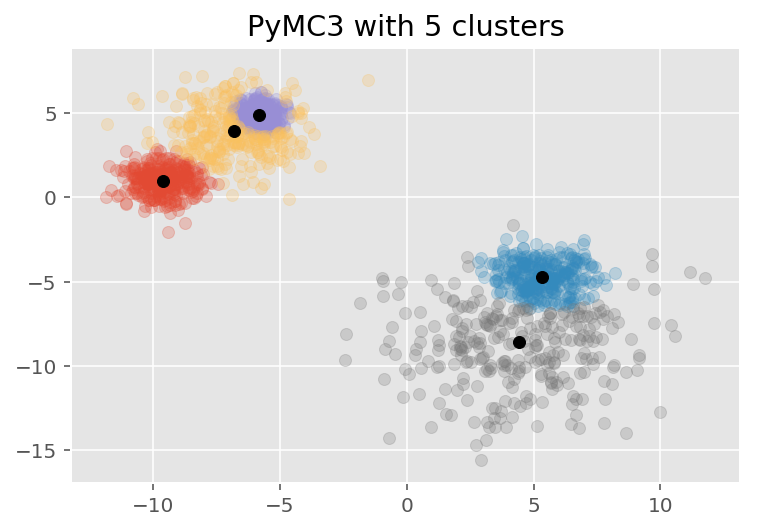

In [27]:
y_ = np.argmax(f_complogp(point), axis=1)
for i in range(len(cluster_std)):
    plt.scatter(X[y_==i, 0], X[y_==i, 1], alpha=.25);
    plt.scatter(point['mu%i'%i][0], point['mu%i'%i][1], c='k')
plt.title("PyMC3 with %s clusters" %nk);

In [32]:
with model:
    approx=pm.FullRankADVI()
    approx.fit(100000)

Average Loss = 8,433: 100%|██████████| 100000/100000 [04:48<00:00, 346.55it/s] 
Finished [100%]: Average Loss = 8,434.9


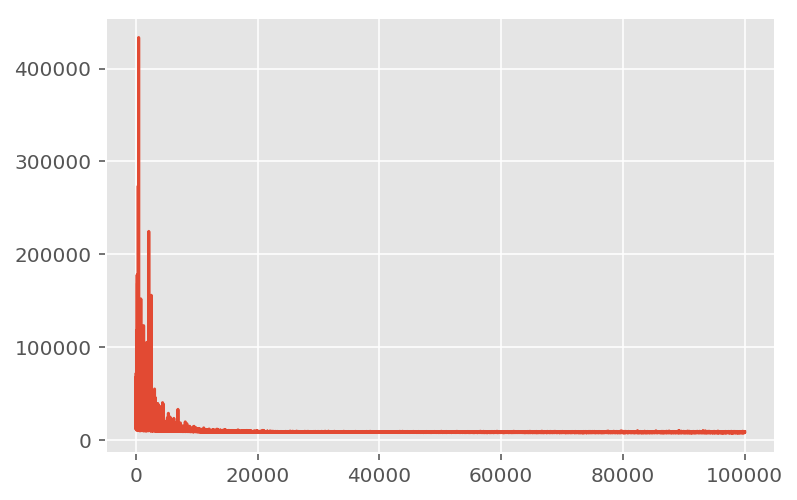

In [33]:
plt.plot(approx.hist);

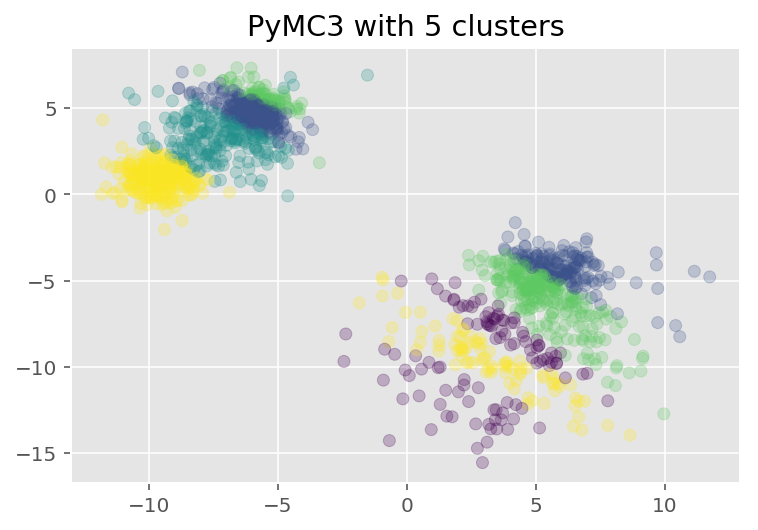

In [34]:
trace = approx.approx.sample(1000)
for i in range(len(cluster_std)):
    point['mu%i'%i] = np.mean(trace['mu%i'%i], axis=0)
    chollabel = 'chol_cov_%i_cholesky-cov-packed__'%i
    point[chollabel] = np.mean(trace[chollabel], axis=0)

y_ = np.argmax(f_complogp(point), axis=1)
plt.scatter(X[:, 0], X[:, 1], c=y_, cmap=plt.cm.viridis, alpha=.25);
plt.title("PyMC3 with %s clusters" %nk);

In [14]:
K = 15
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

# Log likelihood of Gaussian mixture distribution
from pymc3.math import logsumexp
solver = tt.slinalg.Solve(A_structure="lower_triangular", lower=True)
def GMM_logp(weight, mus, chol):
    def logp_(value):
        Ncomp = len(chol)
        logps = []
        for i in range(Ncomp):
            mu = mus[:, i]
            chol_cov = chol[i]
            k = chol_cov.shape[0]

            delta = value.reshape((-1, k)) - mu
            delta_trans = solver(chol_cov, delta.T)

            result = k * tt.log(2 * np.pi)
            result += 2.0 * tt.sum(tt.log(tt.nlinalg.diag(chol_cov)))
            result += (delta_trans ** 2).sum(axis=0).T
            logps.append(tt.log(weight[i]) + -0.5*result)
        return tt.sum(logsumexp(tt.stacklists(logps), axis=0))
    return logp_
    
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))
                         
    sd_dist = []
    packed_chol = []
    chol = []
    for i in range(K):
        sd_dist.append(pm.HalfCauchy.dist(beta=2.5))
        packed_chol.append(pm.LKJCholeskyCov('chol_cov_%i'%i, eta=2, n=2, sd_dist=sd_dist[i]))
        chol.append(pm.expand_packed_triangular(2, packed_chol[i], lower=True))
    
    mus = pm.Normal('mu', 0, sd=10, shape=(2, K))
    obs = pm.DensityDist('obs', GMM_logp(w, mus, chol), observed=X)
    
#     trace = pm.sample(1e4, step=pm.Metropolis())
    
    # ADVI
    s = theano.shared(pm.floatX(1))
    inference = pm.ADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    pm.fit(n=20000, method=inference)
    # It is time to set `s` to zero
    s.set_value(0)
    approx = inference.fit(n=10000)

    trace = approx.sample(2000)
    elbos1 = -inference.hist

Average Loss = 7,094.4: 100%|██████████| 20000/20000 [01:40<00:00, 198.61it/s]
Finished [100%]: Average Loss = 7,094.3
Average Loss = 7,075.4: 100%|██████████| 10000/10000 [00:49<00:00, 201.99it/s]
Finished [100%]: Average Loss = 7,075.4


In [7]:
# # Log likelihood of normal distribution
# def logp_normal(mu, tau, value):
#     # log probability of individual samples
#     k = tau.shape[0]
#     delta = lambda mu: value - mu
#     return (-1 / 2.) * (k * tt.log(2 * np.pi) + tt.log(1./det(tau)) +
#                          (delta(mu).dot(tau) * delta(mu)).sum(axis=1))

# # Log likelihood of Gaussian mixture distribution
# def logp_gmix(mus, pi, tau):
#     def logp_(value):        
#         logps = [tt.log(pi[i]) + logp_normal(mu, tau, value)
#                  for i, mu in enumerate(mus)]
            
#         return tt.sum(logsumexp(tt.stacklists(logps)[:, :n_samples], axis=0))

#     return logp_

# with pm.Model() as model:
#     mus = [pm.MvNormal('mu_%d' % i, mu=np.zeros(2), tau=0.1 * np.eye(2), shape=(2,))
#            for i in range(K)]
#     pi = pm.Dirichlet('w', a=np.ones(K), shape=(K,))
#     xs = pm.DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=X)
    
#     # ADVI
#     s = theano.shared(pm.floatX(1))
#     inference = pm.ADVI(cost_part_grad_scale=s)
#     # ADVI has nearly converged
#     pm.fit(n=50000, method=inference)
#     # It is time to set `s` to zero
#     s.set_value(0)
#     approx = inference.fit(n=20000)

#     trace = approx.sample(2000)
#     elbos1 = -inference.hist

In [8]:
# with pm.Model() as model:
#     alpha = pm.Gamma('alpha', 1., 1.)
#     beta = pm.Beta('beta', 1., alpha, shape=K)
#     w0 = stick_breaking(beta)
#     # use sort to break multimodality
#     w = pm.Deterministic('w', tt.sort(w0))
    
#     mus = pm.Normal('mu', 0, sd=10, shape=(2, K))
#     Mvdist = [pm.MvNormal.dist(mu=mus[:, i], tau=np.eye(2), shape=(2,))
#            for i in range(K)]
    
#     xs = pm.Mixture('x', w, Mvdist, observed=X)
    
#     # ADVI
#     s = theano.shared(pm.floatX(1))
#     inference = pm.ADVI(cost_part_grad_scale=s)
#     # ADVI has nearly converged
#     pm.fit(n=50000, method=inference)
#     # It is time to set `s` to zero
#     s.set_value(0)
#     approx = inference.fit(n=20000)

#     trace = approx.sample(2000)
#     elbos1 = -inference.hist

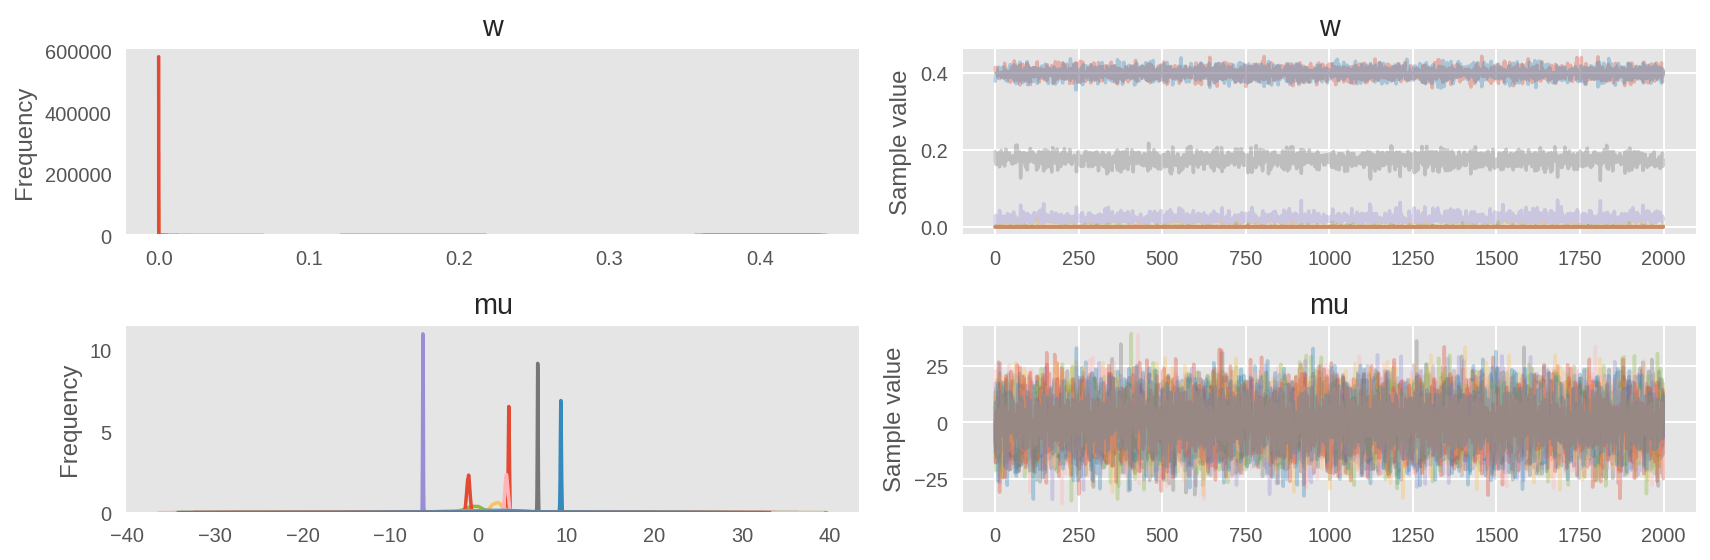

In [15]:
pm.traceplot(trace, varnames=['w', 'mu']);

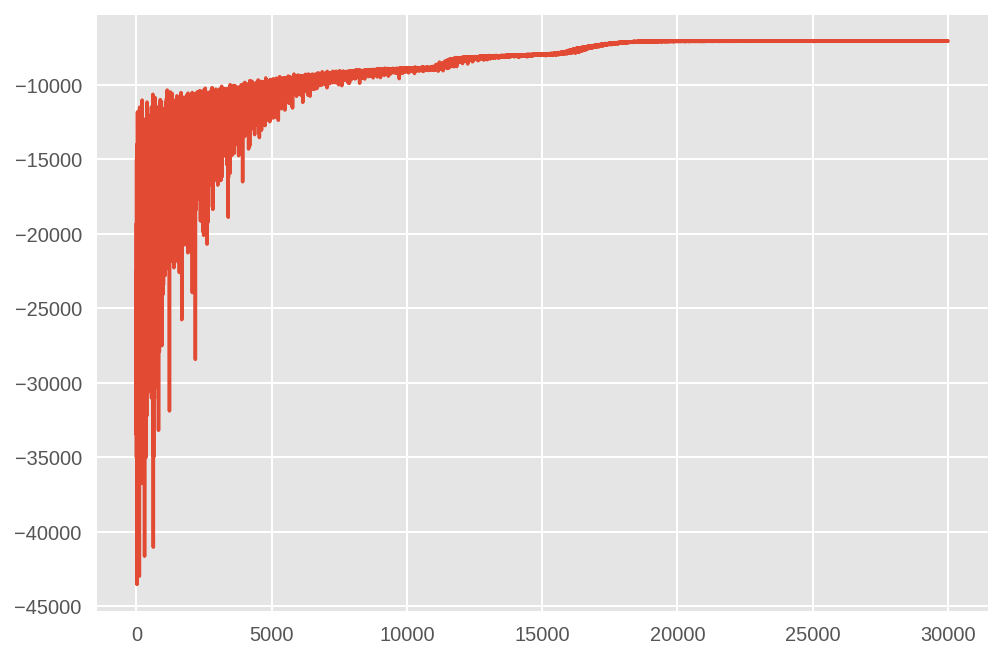

In [16]:
plt.plot(elbos1);

In [17]:
burnin=0
dpgmm.weights_ = trace[burnin:]['w'].mean(axis=0)
dpgmm.means_ = trace[burnin:]['mu'].mean(axis=0).T

In [18]:
cov_pymc3 = []
idx = np.tril_indices(2)
for i in range(K):
    chol = np.zeros((2, 2))
    chol[idx] = trace[burnin:]['chol_cov_%i'%i].mean(axis=0)
    cov_pymc3.append(np.dot(chol, chol.T))
cov_pymc3 = np.asarray(cov_pymc3)
cov_pymc3.shape

dpgmm.covariances_ = cov_pymc3

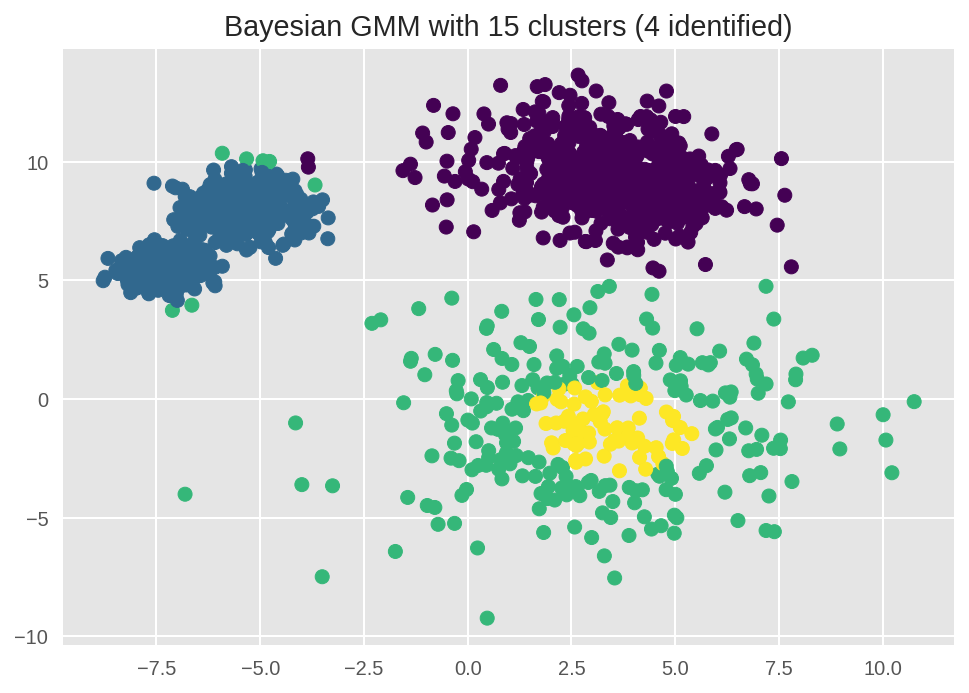

In [19]:
y3 = dpgmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y3, cmap=plt.cm.viridis);
plt.title("Bayesian GMM with %s clusters (%s identified)" % (K, len(np.unique(y3))));

# Using Edward

based on https://github.com/blei-lab/edward/blob/master/notebooks/unsupervised.ipynb

The Joint Version, which includes an explicit latent variable for the mixture assignments.

In [20]:
import tensorflow as tf
import edward as ed
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture, Empirical
    
N, D = X.shape
pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)}, MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat

The Collapsed Version, which marginalizes out the mixture assignments

In [21]:
# from edward.models import Categorical, Dirichlet, InverseGamma, Mixture, \
#     MultivariateNormalDiag, Normal

# K = 2  # number of components

# pi = Dirichlet(tf.ones(K))
# mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
# sigma = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
# cat = Categorical(probs=pi, sample_shape=N)
# components = [
#     MultivariateNormalDiag(mu[k], sigma[k], sample_shape=N)
#     for k in range(K)]
# x = Mixture(cat=cat, components=components)

Inference (using the Joint version)

In [22]:
T = 5000  # number of MCMC samples
qpi = Empirical(tf.Variable(tf.ones([T, K]) / K))
qmu = Empirical(tf.Variable(tf.zeros([T, K, D])))
qsigmasq = Empirical(tf.Variable(tf.ones([T, K, D])))
qz = Empirical(tf.Variable(tf.zeros([T, N], dtype=tf.int32)))

inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz}, data={x: X})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    t = info_dict['t']
    if t % inference.n_print == 0:
        print("\nInferred cluster means:")
        print(sess.run(running_cluster_means, {t_ph: t - 1}))

 500/5000 [ 10%] ███                            ETA: 102s | Acceptance Rate: 1.000
Inferred cluster means:
[[-1.31030941  7.97568703]
 [ 0.86082578  0.08955669]
 [ 0.82198203 -0.18774194]
 [ 1.34062648 -1.58093321]
 [ 1.12346804  0.2983228 ]
 [ 0.43825948 -0.1975376 ]
 [ 0.50218964 -0.08034224]
 [ 1.86597586 -0.85486853]
 [ 0.33454329 -0.24892819]
 [ 1.82235038 -1.2938205 ]
 [ 0.4203538  -0.34371781]
 [ 0.38131663 -0.23772934]
 [ 1.64471042  0.08742063]
 [ 0.37332332 -0.47447374]
 [ 0.35014892 -0.06556707]]
1000/5000 [ 20%] ██████                         ETA: 87s | Acceptance Rate: 1.000 
Inferred cluster means:
[[-3.68214107  7.38083553]
 [ 0.50810486 -0.03981917]
 [ 0.60355574 -0.22759908]
 [ 0.94999248 -0.92895943]
 [ 0.73332924  0.09105176]
 [ 0.31910807 -0.10168462]
 [ 0.54094827 -0.12920713]
 [ 2.74310088 -1.01081562]
 [ 0.42261443 -0.17793563]
 [ 1.05226016 -0.63684529]
 [ 0.29503748 -0.35278061]
 [ 0.43042356 -0.21542852]
 [ 1.09704089 -0.13365409]
 [ 1.91069949  4.30734348]
 [

In [23]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
mu_sample = qmu.sample(100)
sigmasq_sample = qsigmasq.sample(100)
x_post = Normal(loc=tf.ones([N, 1, 1, 1]) * mu_sample,
                scale=tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample))
x_broadcasted = tf.tile(tf.reshape(X, [N, 1, 1, D]), [1, 100, K, 1])

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)

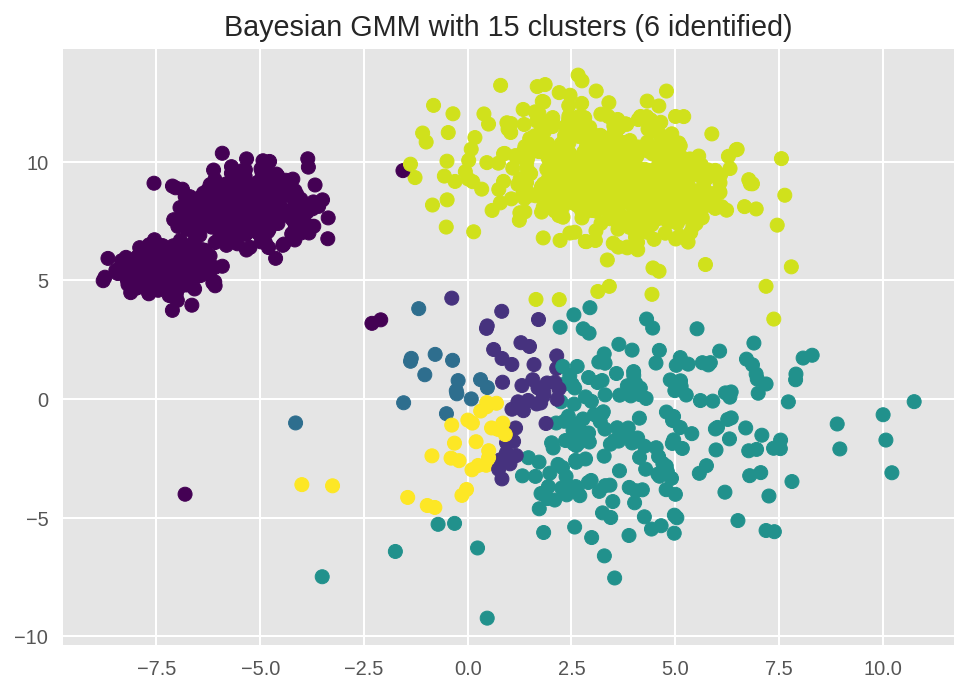

In [24]:
y4 = tf.argmax(log_liks, 1).eval()
plt.scatter(X[:, 0], X[:, 1], c=y4, cmap=plt.cm.viridis);
plt.title("Bayesian GMM with %s clusters (%s identified)" % (K, len(np.unique(y4))));

Currently, this is not working too well yet. To improve from here, it might be necessary to follow [Kamary, Lee & Robert (2017)](https://arxiv.org/pdf/1601.01178.pdf), or the more classical [Expectation Propagation](https://tminka.github.io/papers/ep/minka-ep-uai.pdf). It doesn't hurt also to revisited the relevant chapters in Christopher Bishop's Pattern Recognition and Machine Learning.
Better sampling/fitting could be archived by utilising the composing inferences in PyMC3 or [Edward](http://edwardlib.org/api/inference-compositionality) (by implementing the special models as described in the papers mentioned above).